In [8]:
# Importación de librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Carga del dataset desde la URL
url = 'https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip'
df = pd.read_csv(url)

# Selección de la columna de temperatura y escalado
data = df['T (degC)'].values.reshape(-1, 1)  # Convertimos a un arreglo 2D para escalado
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)



In [9]:
# Función para crear secuencias de entrada (X) y salida (y)
def create_sequences(data, seq_length=72):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Definición de la longitud de la secuencia y creación de los conjuntos de entrenamiento y prueba
seq_length = 72  # 3 días de observaciones
X, y = create_sequences(data_scaled, seq_length)

# División en entrenamiento y prueba (80% entrenamiento, 20% prueba)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]




In [12]:
# Creación del modelo LSTM
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

# Compilación del modelo con optimizador Adam y función de pérdida MAE
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mae')



In [13]:
# Configuración de early stopping para evitar sobreajuste
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenamiento del modelo
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10,
                    batch_size=64, callbacks=[early_stopping], verbose=1)



Epoch 1/10
5256/5256 [==============================] - 507s 96ms/step - loss: 0.0168 - val_loss: 0.0046
Epoch 2/10
5256/5256 [==============================] - 501s 95ms/step - loss: 0.0088 - val_loss: 0.0028
Epoch 3/10
5256/5256 [==============================] - 505s 96ms/step - loss: 0.0083 - val_loss: 0.0042
Epoch 4/10
5256/5256 [==============================] - 504s 96ms/step - loss: 0.0081 - val_loss: 0.0044
Epoch 5/10
5256/5256 [==============================] - 504s 96ms/step - loss: 0.0080 - val_loss: 0.0027
Epoch 6/10
5256/5256 [==============================] - 502s 95ms/step - loss: 0.0079 - val_loss: 0.0029
Epoch 7/10
5256/5256 [==============================] - 501s 95ms/step - loss: 0.0079 - val_loss: 0.0047
Epoch 8/10
5256/5256 [==============================] - 499s 95ms/step - loss: 0.0078 - val_loss: 0.0042
Epoch 9/10
5256/5256 [==============================] - 497s 95ms/step - loss: 0.0078 - val_loss: 0.0036
Epoch 10/10
5256/5256 [==============================] 

2628/2628 [==============================] - 54s 20ms/step


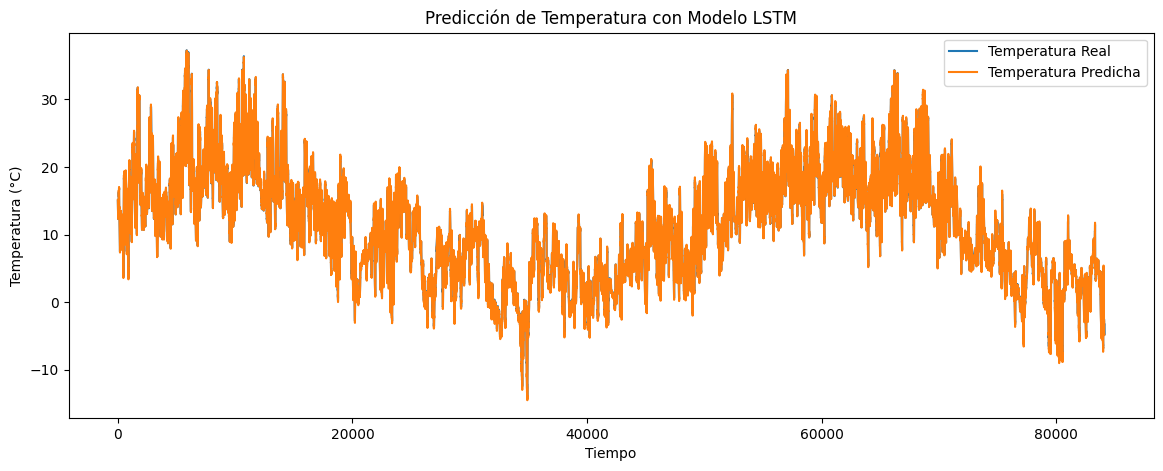

In [14]:
# Predicción en el conjunto de prueba
y_pred = model.predict(X_test)

# Desescalado de los datos para visualización
y_test_unscaled = scaler.inverse_transform(y_test)
y_pred_unscaled = scaler.inverse_transform(y_pred)

# Visualización de los resultados
plt.figure(figsize=(14, 5))
plt.plot(y_test_unscaled, label='Temperatura Real')
plt.plot(y_pred_unscaled, label='Temperatura Predicha')
plt.xlabel('Tiempo')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.title('Predicción de Temperatura con Modelo LSTM')
plt.show()

